# Preliminaries

In [1]:
# import modules
import numpy as np
#... # your code here
from sklearn.datasets import load_digits
import sklearn.ensemble as skens
import matplotlib.pyplot as plt
import seaborn as sns # If not install, install via conda install seaborn

In [2]:
# base classes

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

# Density Tree

In [3]:
class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()
        
    def train(self, data, prior, n_min=20):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D)) # number of features to consider for each split decision

        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = np.min(data, axis=0), np.max(data, axis=0)
        self.box = m.copy(), M.copy()
        
        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features   = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1

        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                ... # your code here
                # compute D_try many feature_indices
                feature_indices = np.random.permutation(np.arange(D))[0:D_try]
                l, r = make_density_split_node(node, N, feature_indices)
                stack.append(l)
                stack.append(r)
            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                #... # your code here
                make_density_leaf_node(node, N)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise
        #return ... # your code here
        m, M = leaf.box

        if (m <= x).all() and (x <= M).all():
            return leaf.response * self.prior
        else:
            return 0

<span style = "color: green; font-weight: bold">The `feature_indices` should be selected only from the valid features. The rest is correct.</span >

In [4]:
def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    m, M = node.box
    
    # compute Volume of parent box
    V = np.prod(np.subtract(M, m))

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
    
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 
        # 'np.unique()'. Describe here why this is necessary.
        
        # ANSWER: See Markdown Cell below
        
        data_unique = np.sort(np.unique(node.data[:, j]))
        # Compute candidate thresholds
        tj = [0.5*(data_unique[i] + data_unique[i+1]) for i in range(len(data_unique)-1)]
        
        # Illustration: for loop - hint: vectorized version is possible
        # TODO: vectorize
        for t in tj:
            # Compute the error
            # compute number of instances going to left and right child
            N_l = np.count_nonzero(node.data[:,j] <= t)
            N_r = n - N_l
            
            # compute volume of left and right child bounding box as a fraction of the parent bb volume
            V_l = (t - m[j])/(M[j]-m[j]) * V
            V_r = (M[j] - t)/(M[j]-m[j]) * V
            
            # use leave-one-out error formula from the exercise sheet
            err_l = N_l/(N * V_l)*(N_l/N - 2*(N_l -1)/(N-1))
            err_r = N_r/(N * V_r)*(N_r/N - 2*(N_r -1)/(N-1))
            loo_error = err_l + err_r
            
            # choose the best threshold that
            if loo_error < e_min:
                e_min = loo_error
                j_min = j
                t_min = t

    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] <= t_min] # store data in left node -- for subsequent splits
    M_l = np.copy(M)
    M_l[j_min] = t_min
    left.box = m, M_l # store bounding box in left node
    right.data = node.data[node.data[:,j_min] > t_min]
    m_r = np.copy(m)
    m_r[j_min] = t_min
    right.box = m_r, M

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

<span style = "color: green; font-weight: bold">Equivalent to sample solution.</span >

We need to remove duplicate feature values, because otherwise it could happen that a threshold is placed "between" two equal feature values, so it will be equal to both of them. 
This is a big problem, if these values lie on the edge of the current bounding box, because then a bounding box of empty volume will be created, which later leads to a division-by-zero-error, when we divide by the volume of that box in the computation of the error.

<span style = "color: green; font-weight: bold">Correct justification.</span >

In [5]:
def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    n = node.data.shape[0]
    m, M = node.box
    v = np.prod(np.subtract(M, m))
    node.response = n/(N*v)

<span style = "color: green; font-weight: bold">Right.</span >

# Decision Tree

In [6]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                #... # your code here
                # compute D_try many feature_indices
                feature_indices = np.random.permutation(np.arange(D))[0:D_try]
                l, r = make_decision_split_node(node, feature_indices)
                stack.append(l)
                stack.append(r)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                #... # your code here
                make_decision_leaf_node(node)
                
    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return leaf.response # your code here

In [7]:
def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    #... # your code here
    g_min = float("inf")
    j_min, t_min = None, None
    
    for j in feature_indices:        
        data_unique = np.sort(np.unique(node.data[:, j]))
        # Compute candidate thresholds
        tj = [0.5*(data_unique[i] + data_unique[i+1]) for i in range(len(data_unique)-1)]
        
        # Illustration: for loop - hint: vectorized version is possible
        # TODO: vectorize
        for t in tj:
            ## Compute the gini impurity for each child (taking the /N^2 out of the sum to speed up computations)
            
            # compute which instances are going to left and right child
            l = node.data[node.data[:,j] <= t]
            N_l = len(l)
            r = node.data[node.data[:,j] > t]
            N_r = len(r)
            
            g_l = N_l^2
            g_r = N_r^2
            for i in range(10):
                g_l -= (np.count_nonzero(l == i))^2
                g_r -= (np.count_nonzero(r == i))^2
            
            # compute sum of gini impurities
            loo_gini = g_l/N_l + g_r/N_l
            
            # choose the best threshold that
            if loo_gini < g_min:
                g_min = loo_gini
                j_min = j
                t_min = t

    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] <= t_min] # data in left node
    left.labels = node.labels[node.data[:,j_min] <= t_min]  # corresponding labels
    right.data = node.data[node.data[:,j_min] > t_min]
    right.labels = node.labels[node.data[:,j_min] > t_min]

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right    

In [8]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = len(node.labels)    
    node.response = np.argmax(np.bincount(node.labels)) # your code here

In [9]:
def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    return (len(np.unique(node.labels)) == 1) # your code here

<span style = "color: green; font-weight: bold">Correct and similar to sample solution. Here, the majority vote is implemented already in `make_decision_leaf_node` (which the sample solution does later), which is fine to do.</span >

# Evaluation of Density and Decision Tree

In [10]:
# read and prepare the digits data
#... # your code here
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(target_names)

[0 1 2 3 4 5 6 7 8 9]


### Density Tree

Text(0.5, 1, 'Conf Matrix')

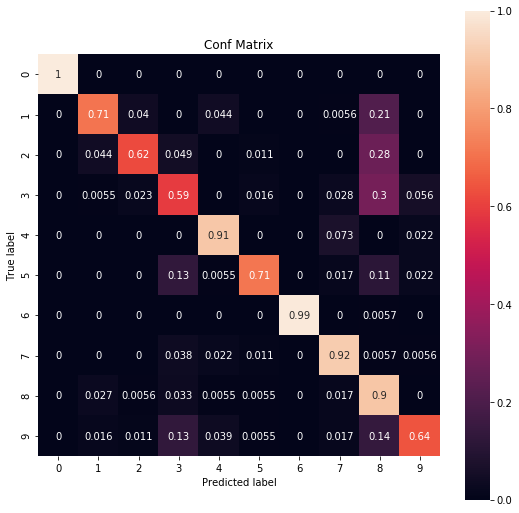

In [11]:
# train trees, plot training error confusion matrices, and comment on your results
#... # your code here

digits = []
density_trees = []
conf_mat = np.zeros((10, 10))

for i in range(10):
    digit = data[target == i]
    digits.append(digit)
    tree = DensityTree()
    tree.train(digit, len(digit)/len(data))
    density_trees.append(tree)
    
for i, x in enumerate(data):
    predictions = []
    for tree in density_trees:
        predictions.append(tree.predict(x))
    pred = np.array(predictions)
    res = np.argmax(pred)
    conf_mat[target[i], res] += 1


# normalize entries in each row    
conf_mat = conf_mat / np.sum(conf_mat, axis=1)

# Plot confusion matrix
figure = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat, annot=True, vmin = 0, vmax = 1, xticklabels = target_names, yticklabels = target_names, square = True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Conf Matrix')

It seems, that the Density Tree has problems choosing the label for 1, 2 and 3 and mostly classifies them as 8. Also it has problems with classifing 9s, with 24% classified as 3.

<span style = "color: green; font-weight: bold">Nice implementation and visual representation that clearly shows which values are frequently falsely classified by the DensityTree.</span >

### Decision Tree

Text(0.5, 1, 'Conf Matrix')

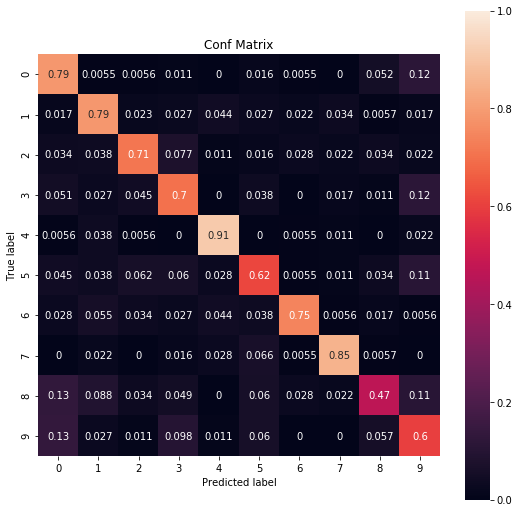

In [12]:
# train trees, plot training error confusion matrices, and comment on your results
#... # your code here
   
tree = DecisionTree()
tree.train(data, target)

conf_mat = np.zeros((10, 10))
    
for i, x in enumerate(data):
    res = tree.predict(x)
    conf_mat[target[i], res] += 1


# normalize entries in each row    
conf_mat = conf_mat / np.sum(conf_mat, axis=1)

# Plot confusion matrix
figure = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat, annot=True, vmin = 0, vmax = 1, xticklabels = target_names, yticklabels = target_names, square = True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Conf Matrix')

The Decision Tree looks better than the Densitiy Tree, but it still has problems with the digits 8 and 9 and overall good, but not really good scores.

<span style = "color: green; font-weight: bold">Good solution and description.</span >

# Density and Decision Forest

In [13]:
class DensityForest():
    def __init__(self, n_trees, n_label):
        # create ensemble
        self.n_label = n_label
        self.trees = [[DensityTree() for i in range(n_label)] for j in range(n_trees)]
    
    def train(self, data, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            ... # your code here
            for pred in self.trees:
                for i,tree in enumerate(pred):
                    digit = data[target == i]
                    tree.train(digit, len(digit)/len(data),n_min=n_min)

    def predict(self, x):
        # compute the ensemble prediction
        predictions = np.zeros(self.n_label)
        for pred in self.trees:
            for i,tree in enumerate(pred):
                predictions[i] += tree.predict(x)
        res = np.argmax(predictions)
        return res

In [14]:
class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]
    
    def train(self, data, labels, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            tree.train(data, target, n_min=n_min)

    def predict(self, x):
        # compute the ensemble prediction
        result = np.zeros(len(target_names))
        for tree in self.trees:
            res = tree.predict(x)
            result[res] += 1
        return np.argmax(result) # your code here

<span style = "color: green; font-weight: bold">Comments see below.</span >

# Evaluation of Density and Decision Forest

Text(0.5, 1, 'Conf Matrix')

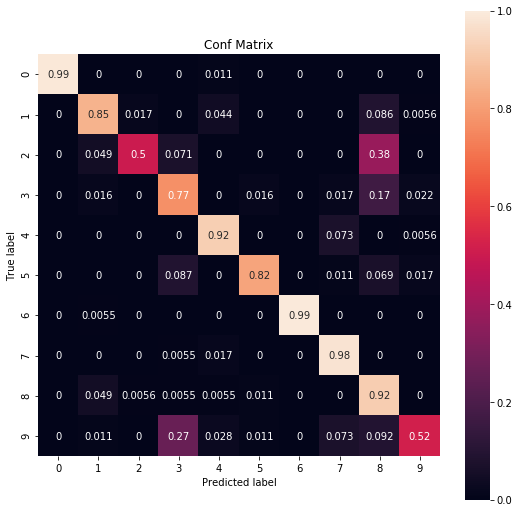

In [15]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
... # your code here
denFor = DensityForest(10,len(target_names))
denFor.train(data)

conf_mat = np.zeros((10, 10))
for i, x in enumerate(data):
    res = denFor.predict(x)
    conf_mat[target[i], res] += 1
    
# normalize entries in each row    
conf_mat = conf_mat / np.sum(conf_mat, axis=1)

# Plot confusion matrix
figure = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat, annot=True, vmin = 0, vmax = 1, xticklabels = target_names, yticklabels = target_names, square = True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Conf Matrix')

As a forest, the density tree gets better accuracy overall, but still has to fight with 2 and 3, as well as 9, with the same problems it has had in the tree part. Using more trees will help, but it is not perfect.

Text(0.5, 103.73999999999997, 'Predicted label')

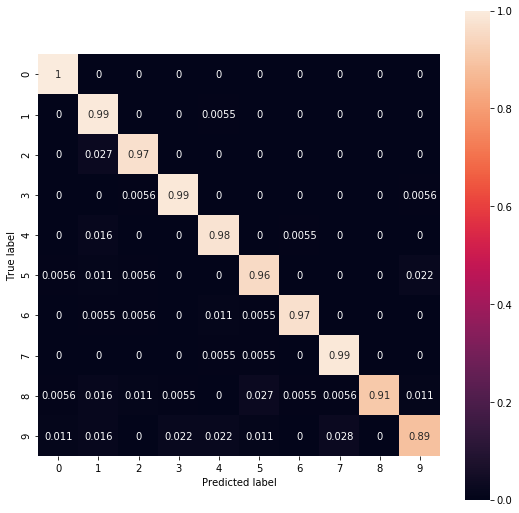

In [16]:
decFor = DecisionForest(20)
decFor.train(data, target)

conf_mat = np.zeros((10, 10))
for i, x in enumerate(data):
    res = decFor.predict(x)
    conf_mat[target[i], res] += 1
    
# normalize entries in each row    
conf_mat = conf_mat / np.sum(conf_mat, axis=1)

# Plot confusion matrix
figure = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat, annot=True, vmin = 0, vmax = 1, xticklabels = target_names, yticklabels = target_names, square = True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

The deciision tree gets much better as a forest, more than the density tree. It still has problems with 8s and 9s, but as a forest the accuracy in this labels goes from roughly 60% to 85%, which is a big bump up. Everything else looks really promissing.

Text(0.5, 103.73999999999997, 'Predicted label')

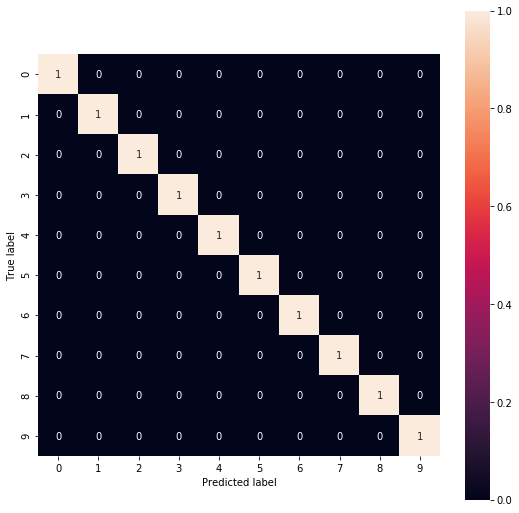

In [17]:
skRF = skens.RandomForestClassifier(20)
skRF.fit(data, target)

conf_mat = np.zeros((10, 10))
for i, x in enumerate(data):
    res = skRF.predict(np.expand_dims(x,axis=0))
    conf_mat[target[i], res] += 1
    
# normalize entries in each row    
conf_mat = conf_mat / np.sum(conf_mat, axis=1)

# Plot confusion matrix
figure = plt.figure(figsize=(9,9))
sns.heatmap(conf_mat, annot=True, vmin = 0, vmax = 1, xticklabels = target_names, yticklabels = target_names, square = True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In comparission to the RandomForestClassifier out of sklearn, both forest implementations have no chance. The sklearn one just shows a perfect confusion matrix over all labels of the trained digits. Analysis could be done on train/test splits with the digits dataset.

<span style = "color: green; font-weight: bold">Seemingly correct solutions and reasonable discussion of the results. The DensityForest has worse performance than the DensityTree for some classes which is not clear why. Perfect comparison to `RandomForestClassifier` from `sklearn.ensemble`.</span >